In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def unet_model(input_shape=(128, 128, 4), num_classes=10):

    image_input = layers.Input(shape=input_shape, name="image_input")
    label_input = layers.Input(shape=(num_classes,), name="label_input")

    # 라벨 데이터를 이미지 크기로 확장
    shape_size = 64
    label_embedding2 = layers.Dense(shape_size * shape_size)(label_input)
    label_embedding2 = layers.Reshape((shape_size, shape_size, 1))(label_embedding2)

    shape_size = 32
    label_embedding3 = layers.Dense(shape_size * shape_size)(label_input)
    label_embedding3 = layers.Reshape((shape_size, shape_size, 1))(label_embedding3)

    shape_size = 16
    label_embedding4 = layers.Dense(shape_size * shape_size)(label_input)
    label_embedding4 = layers.Reshape((shape_size, shape_size, 1))(label_embedding4)


    # 인코더 (Contracting Path)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(image_input)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # 중간 레이어 (Bottleneck)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # 디코더 (Expanding Path)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4, label_embedding4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3, label_embedding3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2, label_embedding2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # 출력 레이어 (Sigmoid를 사용하여 0~1 사이의 확률값으로 출력)
    outputs = layers.Conv2D(4, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[image_input, label_input], outputs=[outputs])
    return model

# 모델 생성 및 컴파일
unet = unet_model(input_shape=(128, 128, 4), num_classes=10)
unet.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
unet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 128, 128, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          2,368 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label_input (InputLayer)  │ (None, 10)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │          2,816 │ label_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose     

 Total params: 31,099,716 (118.64 MB)

 Trainable params: 31,099,716 (118.64 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'NIPA/a-yo-image'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# Change dariectory to current folder
%cd /content/drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/NIPA/a-yo-image


In [4]:
def label_to_one_hot(labels, num_classes, repeat):
  now_label_dataset = np.zeros((num_classes))
  now_label_dataset[labels]  = 1
  now_label_dataset = np.expand_dims(now_label_dataset, axis=0)
  now_label_dataset = np.repeat(now_label_dataset, repeats=repeat, axis=0)
  return now_label_dataset

In [5]:
dataset = np.load('./initial-experiments/mongoose/data/data_run_offset_flip.npy')
# Split into train and validation sets using indexing to optimize memory.

x_dataset = dataset[:,0,:,:,:]
y_dataset = dataset[:,1,:,:,:]
rr  = x_dataset.shape[0]
label_dataset = label_to_one_hot(1,10, rr)

for i in range(8) :
  x_dataset = np.concatenate((x_dataset, dataset[:,0,:,:,:] ), axis = 0)
  y_dataset = np.concatenate((y_dataset, dataset[:,i+2,:,:,:] ), axis = 0)
  label_dataset = np.concatenate((label_dataset, label_to_one_hot(i + 2,10, rr)), axis = 0)

print('data set shape----------------')
print(x_dataset.shape)
print(y_dataset.shape)
print(label_dataset.shape)

indexes = np.arange(x_dataset.shape[0])
np.random.shuffle(indexes)


x_train = x_dataset[indexes[: int(0.9 * x_dataset.shape[0])]]
y_train = y_dataset[indexes[: int(0.9 * x_dataset.shape[0])]]
label_train = label_dataset[indexes[: int(0.9 * x_dataset.shape[0])]]

x_test = x_dataset[indexes[int(0.9 * x_dataset.shape[0]) :]]
y_test = y_dataset[indexes[int(0.9 * x_dataset.shape[0]) :]]
label_test = label_dataset[indexes[int(0.9 * x_dataset.shape[0]) :]]

print('train_data set shape----------------')
print(x_train.shape)
print(y_train.shape)
print(label_train.shape)
print('test_data set shape----------------')
print(x_test.shape)
print(y_test.shape)
print(label_test.shape)

data set shape----------------
(2295, 128, 128, 4)
(2295, 128, 128, 4)
(2295, 10)
train_data set shape----------------
(2065, 128, 128, 4)
(2065, 128, 128, 4)
(2065, 10)
test_data set shape----------------
(230, 128, 128, 4)
(230, 128, 128, 4)
(230, 10)


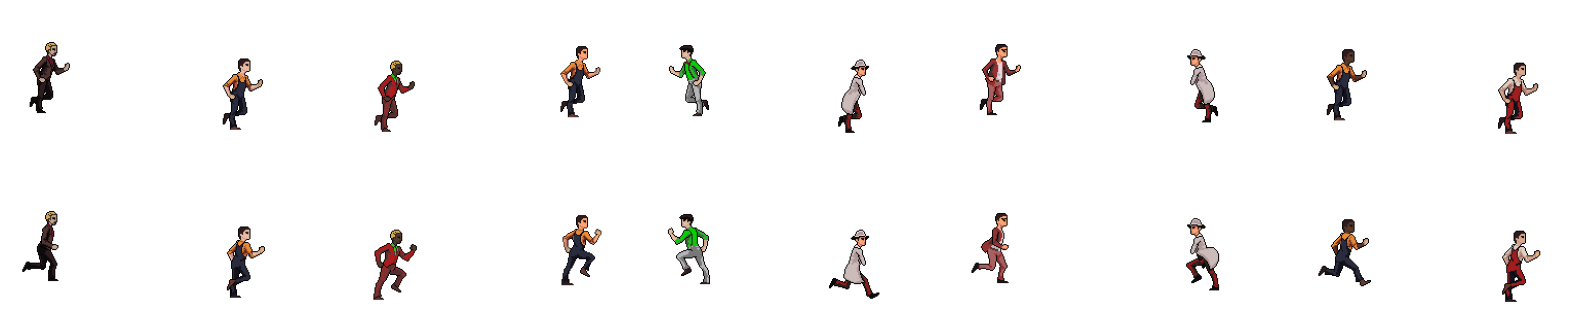

In [6]:
# 원본 이미지 및 재구성 이미지 시각화
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 이미지
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(128, 128, 4), cmap="gray")
    plt.axis("off")

    # 재구성 이미지
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_train[i].reshape(128, 128,4 ), cmap="gray")
    plt.axis("off")
plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# 모델 학습from tensorflow.keras.callbacks import EarlyStopping
# 얼리 스토핑 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',     # 검토할 메트릭 ('val_loss'도 사용 가능)
    patience=10,         # 성능 개선 없이 기다릴 에포크 수
    restore_best_weights=True  # 최상의 가중치를 복원할지 여부
)

# 예시 데이터셋: x_train은 입력 이미지, y_train은 분할 마스크
unet.fit((x_train, label_train), y_train, epochs=20, batch_size=16, shuffle=True,  validation_data=((x_test, label_test), y_test), callbacks=[early_stopping])


Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 97s 428ms/step - accuracy: 0.2117 - loss: 4377.3311 - val_accuracy: 0.2433 - val_loss: 4599.6387
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 82s 214ms/step - accuracy: 0.2768 - loss: 4056.2483 - val_accuracy: 0.2068 - val_loss: 4599.6382
Epoch 3/20
121/130 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.2420 - loss: 3765.7305

In [ ]:
x_test.shape

In [ ]:
x_test_head = x_test[:5, :, :, :]
new_x_test = x_test_head[:1].repeat(10, axis=0)
for i in range(4) :
  new_x_test = np.concatenate((new_x_test, x_test_head[i + 1 : i + 2].repeat(10, axis=0)), axis=0)

In [ ]:
test_label = np.zeros((50, 10))
for i in range(50) :
  test_label[i, i % 10] = 1

In [ ]:
test_label.shape

In [ ]:
decoded_imgs = unet.predict((new_x_test, test_label))

In [ ]:
decoded_imgs = decoded_imgs / 256

In [ ]:
decoded_imgs[0,50,:]

In [ ]:
# 원본 이미지 및 재구성 이미지 시각화
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 이미지
    if i == 0 :
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(x_test[i].reshape(128, 128, 4), cmap="gray")
      plt.axis("off")
    else :
      # 재구성 이미지
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(decoded_imgs[i].reshape(128, 128,4 ), cmap="gray")
      plt.axis("off")
plt.show()